# Descripción del proyecto (Series Temporales)

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

## Flujo de trabajo

1. Descarga de datos y remuestreo por una hora.
2. Analisis de los datos
3. Entrenamiento de diferentes modelos con diferentes hiperparámetros. 
4. Prueba de los datos usando la muestra de prueba (10%) 
4. Uso de la métrica RECM en el conjunto de prueba **no debe ser superior a 48**.
5. Conclusión.

## Descripción de los datos

* Los datos se almacenan en el archivo `taxi.csv`. 	
* El número de pedidos está en la columna `num_orders`.

## Preparación

### Carga de librerias necesarias.

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Carga de informacion

In [1]:
# El CWD
import os
os.chdir(os.getcwd()+"/../") 
print(os.getcwd())

/Users/mau/GitHub/slt_order_demand_prediction


In [4]:
data = pd.read_csv("datasets/raw/taxi.csv",
    index_col=[0], parse_dates=[0]
)
data.sort_index(inplace=True)
data.head()


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data = data.resample('1h').sum()
data.head(15)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Análisis

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<Axes: xlabel='datetime'>

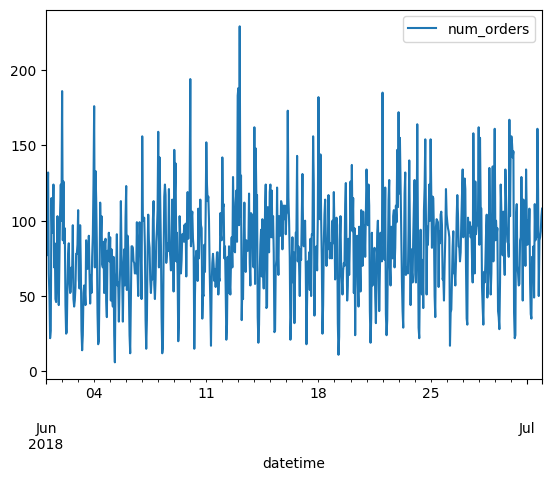

In [7]:
#data.plot()
# Graficando solo un rango para mejor visualizacion
data['2018-06-01':'2018-07-01'].plot()

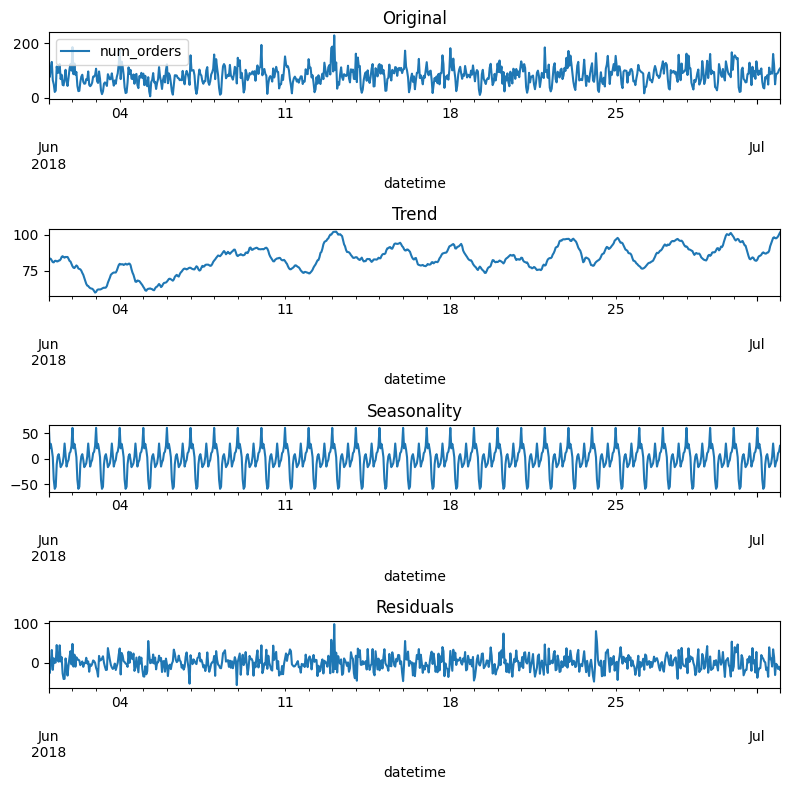

In [11]:
decomposed = seasonal_decompose(data)

# Graficando solo un rango para mejor visualizacion

plt.figure(figsize=(8, 8))

plt.subplot(411)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
data['2018-06-01':'2018-07-01'].plot(ax=plt.gca())
plt.title('Original')

plt.subplot(412)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend['2018-06-01':'2018-07-01'].plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(413)
decomposed.seasonal['2018-06-01':'2018-07-01'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid['2018-06-01':'2018-07-01'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

<Axes: xlabel='datetime'>

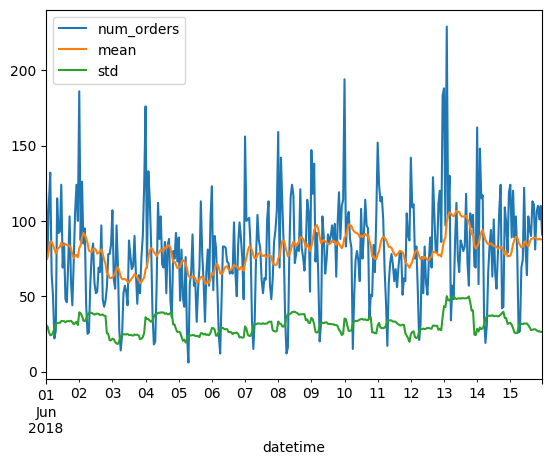

In [12]:
data_t = data.copy()
data_t['mean'] = data_t['num_orders'].rolling(20).mean()
data_t['std'] = data_t['num_orders'].rolling(20).std()

# Graficando solo un rango para mejor visualizacion
data_t['2018-06-01':'2018-06-15'].plot()

NOTA: Se ha descompuesto la serie en tendencia, estacionalidad y residuos, lo que es clave para entender su comportamiento y tomar decisiones informadas a la hora de modelar.  

<Axes: xlabel='datetime'>

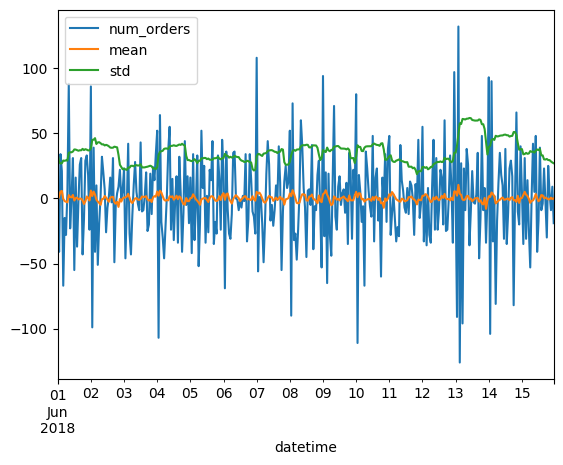

In [13]:
data_t -= data_t.shift()
data_t['mean'] = data_t['num_orders'].rolling(20).mean()
data_t['std'] = data_t['num_orders'].rolling(20).std()
data_t['2018-06-01':'2018-06-15'].plot()

### Comentarios

- Se tiene informacion de las ordenes realizadas desde marzo hasta agosto del 2018 (6 meses)
- Se realizó un resample localizando la informacion acumulada por hora.
- Se logró identificar que se tiene una tendencia relativamente estable hacia la alza con una estacionalidad aproximadamente de un dia (es una serie estacionaria)

## Formación

### Definicion de funciones

In [14]:
def make_features(data, target, max_lag, rolling_mean_size):
    # Caracteristicas de calendario
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    # Caracteristicas de defase
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[target].shift(lag)

    # Media Movil
    data['rolling_mean'] = (
        # Se está considerando descartar el valor actual de la serie
        data[target].shift().rolling(rolling_mean_size).mean()
    )
    
    # Diferencia de serie
    #data['diff'] = data[target]-data[target].shift()
    
    # Se mantiene la serie libre de valores ausentes
    data = data.dropna()
    print(f"Size: {data.shape}")
    return data

### Creación de caracteristicas

In [15]:
data_t = make_features(data.copy(), "num_orders", 12, 6)

Size: (4404, 19)


In [16]:
display(data_t.head())

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,30,2018,3,1,3,12,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,48.333333
2018-03-01 13:00:00,32,2018,3,1,3,13,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,51.333333
2018-03-01 14:00:00,48,2018,3,1,3,14,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,54.166667
2018-03-01 15:00:00,66,2018,3,1,3,15,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,56.500000
2018-03-01 16:00:00,43,2018,3,1,3,16,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.000000


### Division de los datos para el entrenamiento

In [17]:
features_train, features_valid, target_train, target_valid = train_test_split(
    data_t.drop('num_orders', axis=1), 
    data_t.num_orders, 
    shuffle=False,
    test_size=0.1
)

In [18]:
print(
    features_train.shape, features_valid.shape, target_train.shape, target_valid.shape
)

(3963, 18) (441, 18) (3963,) (441,)


### Definicion de modelos

In [19]:
# Se define los modelos a probar
models = {
    'LinearRegression': LinearRegression(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
}

# Se definen los parametros a probar de cada modelo
param_grids = {
    'LinearRegression': {
        'fit_intercept': [True, False],
    },
    'ExtraTreesRegressor': {
        'n_estimators': [70, 100, 130, 160],
        'max_depth': [12, 24, None],
        'bootstrap': [True, False],
        'warm_start': [True, False],
    },
    'RandomForestRegressor': {
        'n_estimators': [70, 100, 130, 160],
        'max_depth': [12, 24, None],
        'bootstrap': [True, False],
        'warm_start': [True, False],
    }
}

### Eleccion de modelos

In [20]:
%%time

# Variables para almacenar los mejores resultados
best_scores = {}
best_params = {}
folds = 5


for model_name, model in models.items():
    print()
    print(f"Tunning for {model_name}...")
    param_grid = param_grids[model_name]
    
    grid_cv_model = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=folds,
        return_train_score=True,
        verbose=1
    )
    #fiting 
    grid_cv_model.fit(features_train,target_train)
    

    # Se almacenan los mejores reslutados
    best_scores[model_name] = grid_cv_model.best_score_
    best_params[model_name] = grid_cv_model.best_params_



Tunning for LinearRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Tunning for ExtraTreesRegressor...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Tunning for RandomForestRegressor...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: user 28min 56s, sys: 35.5 s, total: 29min 31s
Wall time: 34min 35s


In [22]:
print(f"Best Scores: {best_scores}")
print()
print(f"Best Params: {best_params}")


Best Scores: {'LinearRegression': np.float64(-23.54183772334203), 'ExtraTreesRegressor': np.float64(-17.78691482058781), 'RandomForestRegressor': np.float64(-18.211009978532047)}

Best Params: {'LinearRegression': {'fit_intercept': True}, 'ExtraTreesRegressor': {'bootstrap': False, 'max_depth': 24, 'n_estimators': 160, 'warm_start': True}, 'RandomForestRegressor': {'bootstrap': True, 'max_depth': None, 'n_estimators': 130, 'warm_start': False}}


## Prueba

In [38]:
class MyMetrics:
    def __init__(self):
        self.scores = pd.DataFrame(columns = ["model", "set_name", "mse", "rmse", "r2_score"])
        return 

    def collect_metrics(self, model_name, target, prediction, set_name):
        # Getting mean squared error from the model
        mse=mean_squared_error(target, prediction)
        data = {
            "model": model_name,
            "set_name": set_name,
            "mse": mse,
            "rmse": mse**0.5,
            "r2_score": r2_score(target, prediction)
        }
        new_row_df = pd.DataFrame([data])
        self.scores = pd.concat([self.scores, new_row_df], ignore_index=True)
        
        self.scores.drop_duplicates(inplace=True)
        return 
    
    def display_metrics(self, model_name, target, prediction, set_name):
        # Getting mean squared error from the model
        # The coefficient of determination: 1 is perfect prediction
        mse=mean_squared_error(target, prediction)
        
        print()
        print(model_name, " for ", set_name)
        print(f"Mean squared error= {mse:.2f}, RMSE= {mse**0.5:.2f} Coefficient of determination: %.2f" % r2_score(target, prediction))
        return 

### Entrenamiento y Recoleccion de Metricas

In [42]:
my_metrics = MyMetrics()

for model_name, model in models.items():
    params = best_params[model_name]
    
    model = models[model_name]
    model = model.set_params(**params)
    
    #fiting 
    model.fit(features_train,target_train)
    #get predictions and metrics for training
    preds_train = model.predict(features_train)
    my_metrics.collect_metrics(model_name, target_train, preds_train, "train")
    #get predictions and metrics for validation
    preds_valid = model.predict(features_valid)
    my_metrics.collect_metrics(model_name, target_valid, preds_valid, "validation")

/var/folders/9q/x4cx30yj705gp0yp83r_h4c00000gn/T/ipykernel_55443/2808763076.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.scores = pd.concat([self.scores, new_row_df], ignore_index=True)
/Users/mau/GitHub/slt_order_demand_prediction/.venv/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:465: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


### Metricas obtenidas

In [44]:
display(my_metrics.scores.sort_values(by=['set_name', 'rmse']))

,model,set_name,mse,rmse,r2_score
2,ExtraTreesRegressor,train,0.028512,0.168855,0.999981
4,RandomForestRegressor,train,71.672147,8.465940,0.952040
0,LinearRegression,train,905.242597,30.087250,0.394255
5,RandomForestRegressor,validation,1832.722043,42.810303,0.466087
3,ExtraTreesRegressor,validation,1860.194787,43.129975,0.458084
1,LinearRegression,validation,2757.472488,52.511641,0.196687


## Conslusiones

Siguiendo las pistas y requerimientos del ejercicio, se realizaron las siguientes acciones:

1. Se crearon caracteristicas tanto de calendario como de fase. En esta seccion se trabajó creando caracteristicas basicas, sin embargo se identificó agregar la caracteristica de la "hora" debido a que a raiz del analisis se detecta que la estacionalidad es diaria.


2. Se trabajaron con varios Algoritmos y se definieron hiperparametros para cada uno de ellos partiendo de la regresion lineal y la meta a cumplir con las metricas.

    A partir de un GridSearch se seleccionaron los siguientes hiperparametros para obtener las mejores metricas:

<pre>
Best Scores: 
{
    'LinearRegression': -23.54183772334203, 
    <b>'ExtraTreesRegressor': -17.8232773228216, </b>
    'RandomForestRegressor': -18.25617429473987
}

Best Params: 
{
    'LinearRegression': {'fit_intercept': True}, 
    <b>'ExtraTreesRegressor': {'bootstrap': False, 'max_depth': 24, 'n_estimators': 100, 'warm_start': False}, </b>
    'RandomForestRegressor': {'bootstrap': True, 'max_depth': None, 'n_estimators': 70, 'warm_start': False}
}
</pre>
Con lo anterior usando el algoritmo ExtraTreesRegressor se obtuvo un rmse de <b>43.351230</b> para el set de pruebas.

Finalmente, queda en evidencia que es importante analizar la serie y sus caracteristicas para seleccionar un mejor establecimiento de caracteristicas y con ello obtener los mejores resultados.


# Comentarios generales

 
<div class="alert alert-block alert-success">  
       
**Áreas para Seguir Investigando:**  
- **Técnicas avanzadas de feature engineering:** Explorar transformaciones como diferencias de series o características basadas en ventanas de tiempo más complejas.  
- **Optimización de modelos más complejos:** Considerar modelos más avanzados como `XGBoost` o `LSTM` para series temporales.  
- **Manejo de datos desbalanceados:** Si en futuros proyectos la serie muestra alta variabilidad en ciertos períodos, podrías aplicar técnicas como SMOTE o resampling estratégico.  
- **Evaluación con datos futuros:** Implementar un esquema de validación temporal, como `TimeSeriesSplit`, para simular condiciones reales de predicción.  

¡Sigue así, estás haciendo un gran trabajo!  
</div>  